ENGS 106 - Final Project
Authors - Taka Khoo, Doruk, Harry Leiter

<small>


             

    Overall design:

        typedef struct {
            image
            label
        } sample_t


        training(){
            init_network()
            sample = load_datapoint
            output = feedforward(sample->png)
            tocompare = getbackpropdata(sample)
            backprop(output, tocompare)
        }




        gettrainingdata(sample_t sample){
            Case (sample->label):
                1:
                    upscaledimg = upscale(sample->image)
                    gaussian = gaussian(upscaledimg)
                    harmonics = harmonics(gaussian, sample->fundamental_note_for_A_in_hertz)
                    harmonics_smear = gaussian(harmonics)
                    smooth = smooth(harmonics_smear)
                    return trainingcomparison       
                2:
                .
                .
                .
        
        }

        Still need to do init, feedforward, backprop pseudocode
</small>

# Below this markdown are an idea of the functions we could use to condition our data for the purposes of comparison during training

and here is my thinking behind these functions

<small> Create neural network Structure
    - inputs will be numbers 0-7 of mnist dataset (pictures of handwritten digits from 0-7)
        -These inputs will represent the notes of the major scale
    - output
        *Image of a spectrogram
            *Want to look like the input image? (maybe this would allow for more creative experimentation with finalized model than just looking like a letter)
            
            *Image is square, so we would want the output to be square as well
                -I'm not sure what to use for the image (spectrogram resolution):
                    Guessing around 1024x1024
                    
                    ~Training on 1024x1024 input images would probably be too resource intensive, so we might want to
                     upscale input image and then compare to that

                    *maybe drop down to 1008 for easier upscaling (mnist - 24x24 -- 24*36 = 1008 {24*4*3*3} -- esrgan upscaler works in factors of 1,2,3,4 )

            *We could compare the images with readily available tools online

            *In natural musical instruments, harmonics typically die out the further one gets from the fundamental note. Maybe we can
             achieve this by applying a horizontal gaussian filter to the output, and using that to determine loss as well
</small>

In [191]:
 import getpass
 import os


%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install torch
%pip install torchaudio
%pip install torchvision
%pip install numpy
%pip install Pillow
%pip install opencv-python
%pip install scikit-image


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Upscaler:

In [257]:
def upscale(input):
    !cd Upscaler && chmod u+x realesrgan-ncnn-vulkan && ./realesrgan-ncnn-vulkan -i ../{input}.jpg -o ../{input}-upscaled.png -s 3 && ./realesrgan-ncnn-vulkan -i ../{input}-upscaled.png -o ../{input}-upscaled.png -s 3 && ./realesrgan-ncnn-vulkan -i ../{input}-upscaled.png -o ../{input}-upscaled.png -s 4

upscale('thenumber4')
upscale('thenumber5')

[0 Intel(R) Xe Graphics (TGL GT2)]  queueC=0[1]  queueG=0[1]  queueT=0[1]
[0 Intel(R) Xe Graphics (TGL GT2)]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[0 Intel(R) Xe Graphics (TGL GT2)]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[0 Intel(R) Xe Graphics (TGL GT2)]  subgroup=32  basic=1  vote=1  ballot=1  shuffle=1
[1 llvmpipe (LLVM 17.0.6, 256 bits)]  queueC=0[1]  queueG=0[1]  queueT=0[1]
[1 llvmpipe (LLVM 17.0.6, 256 bits)]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[1 llvmpipe (LLVM 17.0.6, 256 bits)]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[1 llvmpipe (LLVM 17.0.6, 256 bits)]  subgroup=8  basic=1  vote=1  ballot=1  shuffle=1
0.00%
[0 Intel(R) Xe Graphics (TGL GT2)]  queueC=0[1]  queueG=0[1]  queueT=0[1]
[0 Intel(R) Xe Graphics (TGL GT2)]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[0 Intel(R) Xe Graphics (TGL GT2)]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[0 Intel(R) Xe Graphics (TGL GT2)]  subgroup=32  basic=1  vote=1  ballot=1  shuffle=1
[1 llvmpipe (LLVM 17.0.6, 256 bits)]  queueC=0[1]  queueG

In [258]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
from PIL import Image
import matplotlib.pyplot as plt


* Gaussian function:

In [259]:
'''
                        This function turns the images vertical axis into a gaussian distribution
'''
def gaussian(image, sigma):

    blurred = gaussian_filter1d(image, sigma=sigma, axis=0)
    return blurred

Applying vertical gaussian to images

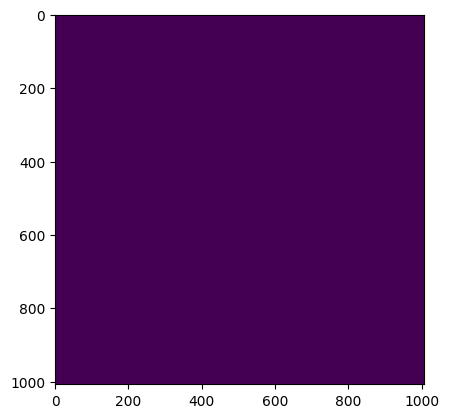

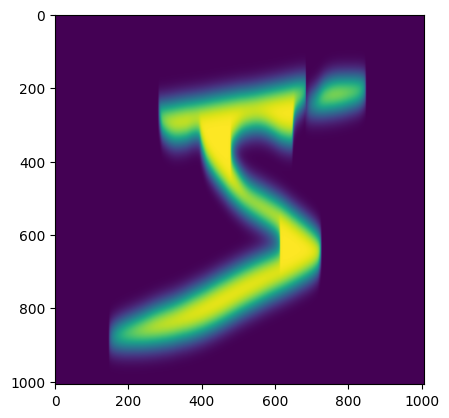

In [260]:
'''
                                            Passing 4 and 5 through gaussian
'''
sd = 30 #sd for vertical gaussian

image = Image.open('thenumber4-upscaled.png').convert('L') #For 4
blurred = gaussian(image, sd)
plt.imshow(blurred)
plt.show()
im = Image.fromarray(blurred).convert('RGB')
im.save("thenumber4-upscaled-blurred.png")
np.save('thenumber4-upscaled-blurred', blurred)

image = Image.open('thenumber5-upscaled.png').convert('L') #For 5
blurred = gaussian(image, sd)
plt.imshow(blurred)
plt.show()
im = Image.fromarray(blurred).convert('RGB')
im.save("thenumber5-upscaled-blurred.png")
np.save('thenumber5-upscaled-blurred', blurred)


Harmonics Extraction:

In [362]:
'''
                            This function extracts the harmonics

                            We could also use this function to extract whatever frequencies we want to keep at whatever time
'''
def harmonics(gaussian, fundamentalnote):
    harmonicsarray = np.zeros((1008,1008))
    for column in range(1008):
        for row in range(1008):
            if((row) % fundamentalnote == 0 or (row) % (1.25 * fundamentalnote)  == 0 or (row) % (1.5 * fundamentalnote) == 0 ):
                harmonicsarray[row, column] = gaussian[row, column]
            else:
                harmonicsarray[row, column] = 0

    return harmonicsarray

Applying to Gaussians (4,5)

/tmp/ipykernel_11056/1560982392.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  harmonicsarray[row, column] = gaussian[row, column] + np.abs(np.random.rand(1))


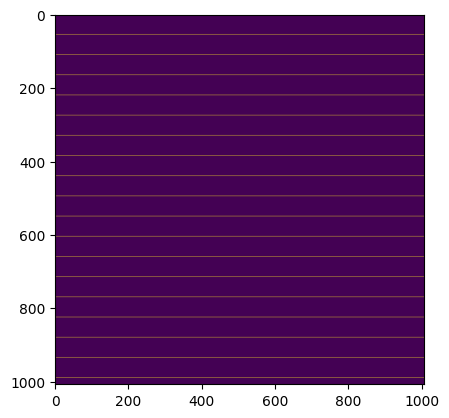

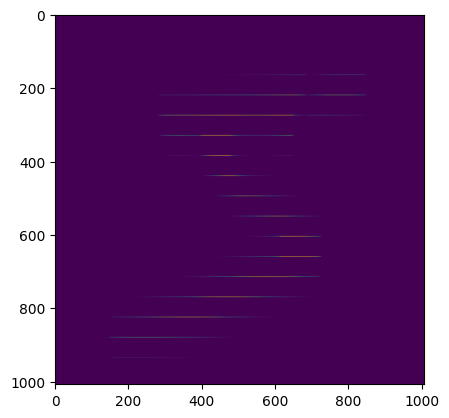

In [363]:
gaussiann = np.load('thenumber4-upscaled-blurred.npy')
harmonic = harmonics(gaussiann, 55)

plt.imshow(harmonic)
plt.show()
im = Image.fromarray(harmonic).convert('RGB')
im.save("thenumber4-upscaled-blurred-harmonics.png")

gaussiann = np.load('thenumber5-upscaled-blurred.npy')
harmonic = harmonics(gaussiann, 55)

plt.imshow(harmonic)
plt.show()
im = Image.fromarray(harmonic).convert('RGB')
im.save("thenumber5-upscaled-blurred-harmonics.png")

Second Gaussian (4,5)

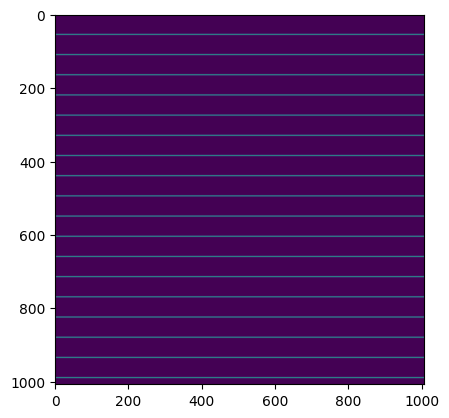

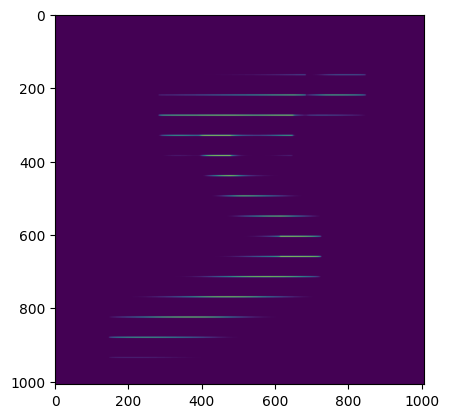

In [402]:
'''
                    Noticed this is very sparse ^, I'm going to apply another gaussian to the harmonics
'''
#for 4
smear = 1
image = Image.open('thenumber4-upscaled-blurred-harmonics.png').convert('L')
secondgaussian = gaussian(image, smear)
im = Image.fromarray(secondgaussian).convert('RGB')
#Normalize
secondgaussian1 = (secondgaussian - secondgaussian.min()) / (secondgaussian.max() - secondgaussian.min()) * 255
im.save("thenumber4-upscaled-blurred-harmonics-smeared.png")

plt.imshow(secondgaussian1)
plt.show()

#for 5

image = Image.open('thenumber5-upscaled-blurred-harmonics.png').convert('L')
secondgaussian = gaussian(image, smear)
im = Image.fromarray(secondgaussian).convert('RGB')
#Normalize
secondgaussian2 = (secondgaussian - secondgaussian.min()) / (secondgaussian.max() - secondgaussian.min()) * 255
im.save("thenumber5-upscaled-blurred-harmonics-smeared.png")

plt.imshow(secondgaussian2)
plt.show()
#Better, but now the gradient isnt smooth

Smoothing function

In [403]:
def smooth(image, sigma):
    image = gaussian_filter(image, sigma = sigma)
    return image

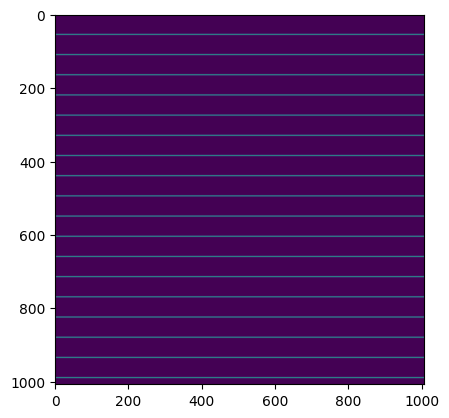

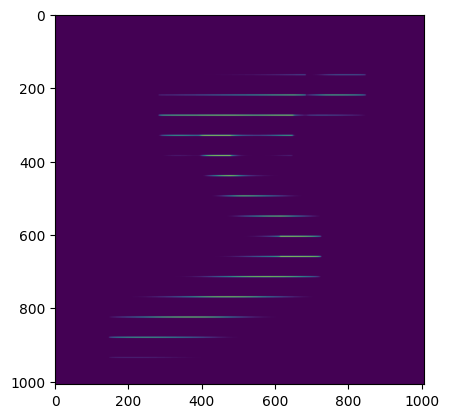

In [404]:
smooth_ = 0

#for 4
smoothed = smooth(secondgaussian1, smooth_)
#Normalize
smoothed = (smoothed  - smoothed.min()) / (smoothed.max() - smoothed.min()) * 255
plt.imshow(smoothed)
plt.show()
im = Image.fromarray(smoothed).convert('RGB')
im.save("thenumber4-upscaled-blurred-harmonics-smeared-smoothed.png")

#for 5
smoothed = smooth(secondgaussian2, smooth_)
#Normalize
smoothed = (smoothed  - smoothed.min()) / (smoothed.max() - smoothed.min()) * 255
plt.imshow(smoothed)
plt.show()
im = Image.fromarray(smoothed).convert('RGB')
im.save("thenumber5-upscaled-blurred-harmonics-smeared-smoothed.png")




* SSIM - I think this one is best
    * Analyzes lower-level structual similarity

In [405]:
#ripped from geeksforgeeks

import cv2
from skimage.metrics import structural_similarity as ssim
# Function to calculate SSIM
def calculate_ssim(imageA, imageB):
    # Convert images to grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Compute SSIM between the two images
    score, _ = ssim(grayA, grayB, full=True)
    return score

imageA = cv2.imread('thenumber4-upscaled-blurred-harmonics-smeared-smoothed.png')
imageB = cv2.imread('thenumber5-upscaled-blurred-harmonics-smeared-smoothed.png')

ssim_score = calculate_ssim(imageA, imageB)
print(f"SSIM score: {ssim_score}")

SSIM score: 0.8416546153347149


Convert spectrogram to wav:

In [406]:
import numpy as np
import cv2
from scipy.io.wavfile import write
from scipy.signal import resample

def convert_to_wav(image, output): 
    duration = 5
    spectrogram = cv2.imread(image, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    sample_rate = 44100
    numsample = int(sample_rate * duration)
    spectrogram = resample(spectrogram, numsample, axis = 1)
    print(spectrogram.shape)
    height, width = spectrogram.shape #Expect 1008x1008

    time = np.linspace(0, duration, width, endpoint=False)
    sinwaves = np.zeros((height, width), dtype = np.float32)

    #Looping over each row which is freq and each column which is time
    for row in range(height):
        offset = 0
        frequency = row + offset
        phase = np.abs(np.random.uniform(0, 2 * np.pi))
        amplitude_envelope = spectrogram[row, :]/255.0
        sinwaves[row, :] = amplitude_envelope * np.sin(2 * np.pi * frequency * time + phase)

    
    combined_signal = sinwaves.sum(axis = 0)


    resampled = resample(combined_signal, numsample)
    resampled /= np.max(np.abs(resampled))

    write(output, sample_rate, resampled.astype(np.float32))

convert_to_wav("thenumber5-upscaled-blurred-harmonics-smeared-smoothed.png", '5.wav')
convert_to_wav("thenumber4-upscaled-blurred-harmonics-smeared-smoothed.png", '4.wav')

(1008, 220500)
(1008, 220500)
